In [1]:
import torch
from PIL import Image
import PIL
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torch.nn import functional as f
import clip

from diffusers import StableDiffusionImg2ImgPipeline
from diffusers.utils import (
    PIL_INTERPOLATION,
)
from torchvision.utils import make_grid
import torchvision

2023-04-26 16:02:33.884068: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 16:02:34.166537: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-26 16:02:34.996010: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-26 16:02:34.996115: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
# load stable diffusion pipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", revision="fp16", torch_dtype=torch.float16, safety_checker=None
).to(device)

# uncomment this if you have troubles with available memory
# pipe.enable_attention_slicing()

# load CLIP mopdel
model, preprocess = clip.load("ViT-L/14", device=device)


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [3]:
# utils tp draw images in one grid
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# preprocessing util
def preprocess1(image):
    if isinstance(image, torch.Tensor):
        return image
    elif isinstance(image, PIL.Image.Image):
        image = [image]

    if isinstance(image[0], PIL.Image.Image):
        w, h = image[0].size
        w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
        print(w, h)

        image = [np.array(i.resize((w, h), resample=PIL_INTERPOLATION["lanczos"]))[None, :] for i in image]
        image = np.concatenate(image, axis=0)
        image = np.array(image).astype(np.float32) / 255.0
        image = image.transpose(0, 3, 1, 2)
        image = 2.0 * image - 1.0
        image = torch.from_numpy(image)
    elif isinstance(image[0], torch.Tensor):
        image = torch.cat(image, dim=0)
    return image

In [4]:
# CLIP classification util
def clip_classify(images, prompts, model):
    
    text_embeddings = model.encode_text(prompts)
    images_embeddings = images

    dots = (images_embeddings @ text_embeddings.T)
    return f.softmax(dots, dim=1)

In [6]:
# add path to your image
init_image = Image.open('/home/sharfikeg/my_files/zero_shot_classification/noise-denoise/to_classify/girl.jpeg').resize((448,448), PIL.Image.Resampling.LANCZOS)
init_image_tensor = preprocess1(init_image)

448 448


In [169]:
# enter your classes of interest

classes = [
    'beauty',
    "rainbow"
]

prompts = [
    f'A highquality photo of a {representative}' for representative in classes
]

images = pipe(prompt=prompts, image=init_image, strength=0.9, guidance_scale=7.5, num_inference_steps=50, num_images_per_prompt=1).images

/home/sharfikeg/anaconda3/envs/myenv/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py:483: FutureWarning: You have passed 2 text prompts (`prompt`), but only 1 initial images (`image`). Initial images are now duplicating to match the number of text prompts. Note that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update your script to pass as many initial images as text prompts to suppress this warning.
  deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/45 [00:00<?, ?it/s]

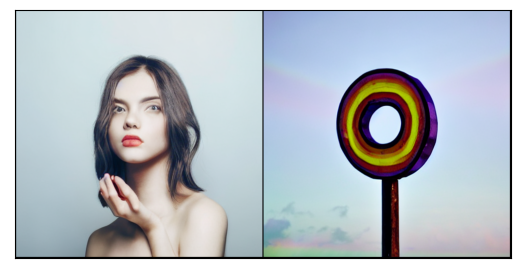

In [170]:
images_tensor_list = [torchvision.transforms.ToTensor()(image) for image in images ]
Grid = make_grid(images_tensor_list, nrow=len(classes))

show(Grid)

In [171]:
# set 'answer' variable to 1 if you want to see the classification results
# set 'answer' variable to 0 if you want to see the generation result
answer = 1
images_tensor_list = [torchvision.transforms.ToTensor()(image) for image in images ]
if answer:
    images_tensor_list_stacked = torch.stack(images_tensor_list, dim=0)
    print(images_tensor_list_stacked.flatten(start_dim=1, end_dim=-1).shape, init_image_tensor.shape)
    results = torch.linalg.norm(images_tensor_list_stacked.flatten(start_dim=1, end_dim=-1)-init_image_tensor.flatten(start_dim=1, end_dim=-1), dim=1)

    init_clip = model.encode_image(preprocess(init_image).unsqueeze(0).to(device))
    clip_results = clip_classify(init_clip, prompts=clip.tokenize(prompts).to(device), model=model)

    recons_clip=model.encode_image( torch.stack([preprocess(image) for image in images], dim=0).to(device))
    results = torch.linalg.norm(recons_clip-init_clip, dim=1)
    print(f'clip decision: {classes[torch.argmax(clip_results).item()]}')
    print(f'diffclip decision: {classes[torch.argmin(results).item()]}')
    # print(f'top-3: 1: {classes[torch.sort(results)[1][0]]}, 2: {classes[torch.sort(results)[1][1]]}, 3: 2: {classes[torch.sort(results)[1][2]]}\nDiff: {torch.sort(results)[0][1]-torch.sort(results)[0][0]}')
else:
    Grid = make_grid(images_tensor_list, nrow=len(classes))

    # display result
    show(Grid)


torch.Size([2, 602112]) torch.Size([1, 3, 448, 448])
clip decision: beauty
diffclip decision: beauty


In [168]:
# to save results
from torchvision.utils import save_image
save_image(Grid, "./sides/sides.jpg")